<a href="https://colab.research.google.com/github/Subtlr/timeseries_sW/blob/main/enviromental_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [660]:
!pip install opendatasets --quiet

In [661]:
import opendatasets as od
dataset_path = r"https://www.kaggle.com/datasets/garystafford/environmental-sensor-data-132k"
od.download(dataset_path)

Skipping, found downloaded files in "./environmental-sensor-data-132k" (use force=True to force download)


In [662]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [663]:
import sklearn as skl
import torch

In [664]:
original_dataframe = pd.read_csv(r"/content/environmental-sensor-data-132k/iot_telemetry_data.csv")

In [665]:
original_dataframe.nunique()

,0
ts,405171
device,3
co,7512
humidity,677
light,2
lpg,7509
motion,2
smoke,7832
temp,231


In [666]:
original_dataframe.head()

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


In [667]:
modified_df = original_dataframe.copy()

modified_df['datetime'] = pd.to_datetime(modified_df['ts'], unit='s')
modified_df.set_index('datetime', inplace=True)

modified_df.head()

,ts,device,co,humidity,light,lpg,motion,smoke,temp
datetime,,,,,,,,,
2020-07-12 00:01:34.385974646,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
2020-07-12 00:01:34.735567570,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2020-07-12 00:01:38.073572874,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
2020-07-12 00:01:39.589145899,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
2020-07-12 00:01:41.761234999,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


In [668]:
device_renamer = {"b8:27:eb:bf:9d:51": "sensor_A", "00:0f:00:70:91:0a": "sensor_B", "1c:bf:ce:15:ec:4d": "sensor_C"}
modified_df['device'] = modified_df['device'].map(device_renamer)

In [669]:
modified_df.drop(columns="ts",inplace=True)

In [670]:
modified_df['light'] = modified_df['light'].astype(int)
modified_df['motion'] = modified_df['motion'].astype(int)

In [671]:
almost_final_df = pd.get_dummies(modified_df)

In [672]:
almost_final_df.head()

,co,humidity,light,lpg,motion,smoke,temp,device_sensor_A,device_sensor_B,device_sensor_C
datetime,,,,,,,,,,
2020-07-12 00:01:34.385974646,0.004956,51.000000,0,0.007651,0,0.020411,22.700000,True,False,False
2020-07-12 00:01:34.735567570,0.002840,76.000000,0,0.005114,0,0.013275,19.700001,False,True,False
2020-07-12 00:01:38.073572874,0.004976,50.900000,0,0.007673,0,0.020475,22.600000,True,False,False
2020-07-12 00:01:39.589145899,0.004403,76.800003,1,0.007023,0,0.018628,27.000000,False,False,True
2020-07-12 00:01:41.761234999,0.004967,50.900000,0,0.007664,0,0.020448,22.600000,True,False,False


In [673]:
normalizer = skl.preprocessing.MinMaxScaler()

In [674]:
almost_final_df.shape[0] * 0.8 - 81037

243110.2

In [675]:
test_og = almost_final_df.iloc[324147:, :]
print(test_og.shape)

(81037, 10)


In [676]:
valid_og = almost_final_df.iloc[243110:324147, :]
print(valid_og.shape)

(81037, 10)


In [677]:
train_og = almost_final_df.iloc[:243110, :]
print(train_og.shape)

(243110, 10)


In [678]:
normalizer = skl.preprocessing.MinMaxScaler()
normalizer.fit(train_og)

train = normalizer.transform(train_og)
valid = normalizer.transform(valid_og)
test = normalizer.transform(test_og)

In [679]:
train = pd.DataFrame(train, columns=train_og.columns, index=train_og.index)
valid = pd.DataFrame(valid, columns=valid_og.columns, index=valid_og.index)
test = pd.DataFrame(test, columns=test_og.columns, index=test_og.index)

In [680]:
train

,co,humidity,light,lpg,motion,smoke,temp,device_sensor_A,device_sensor_B,device_sensor_C
datetime,,,,,,,,,,
2020-07-12 00:01:34.385974646,0.222232,0.632522,0.0,0.271737,0.0,0.262466,0.749175,1.0,0.0,0.0
2020-07-12 00:01:34.735567570,0.048350,0.952625,0.0,0.064572,0.0,0.061412,0.650165,0.0,1.0,0.0
2020-07-12 00:01:38.073572874,0.223881,0.631242,0.0,0.273567,0.0,0.264265,0.745875,1.0,0.0,0.0
2020-07-12 00:01:39.589145899,0.176793,0.962868,1.0,0.220487,0.0,0.212232,0.891089,0.0,0.0,1.0
2020-07-12 00:01:41.761234999,0.223171,0.631242,0.0,0.272778,0.0,0.263490,0.745875,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-07-16 19:04:11.444510460,0.323013,0.656850,0.0,0.380121,0.0,0.369604,0.722772,1.0,0.0,0.0
2020-07-16 19:04:12.211472750,0.118954,0.779770,1.0,0.152578,0.0,0.146146,0.864687,0.0,0.0,1.0
2020-07-16 19:04:15.130992889,0.325375,0.654289,0.0,0.382585,0.0,0.372054,0.722772,1.0,0.0,0.0


In [681]:
train_A = train[train['device_sensor_A'] == 1].drop(columns=["device_sensor_A", "device_sensor_B", "device_sensor_C"])
train_B = train[train['device_sensor_B'] == 1].drop(columns=["device_sensor_A", "device_sensor_B", "device_sensor_C"])
train_C = train[train['device_sensor_C'] == 1].drop(columns=["device_sensor_A", "device_sensor_B", "device_sensor_C"])

valid_A = valid[valid['device_sensor_A'] == 1].drop(columns=["device_sensor_A", "device_sensor_B", "device_sensor_C"])
valid_B = valid[valid['device_sensor_B'] == 1].drop(columns=["device_sensor_A", "device_sensor_B", "device_sensor_C"])
valid_C = valid[valid['device_sensor_C'] == 1].drop(columns=["device_sensor_A", "device_sensor_B", "device_sensor_C"])

test_A = test[test['device_sensor_A'] == 1].drop(columns=["device_sensor_A", "device_sensor_B", "device_sensor_C"])
test_B = test[test['device_sensor_B'] == 1].drop(columns=["device_sensor_A", "device_sensor_B", "device_sensor_C"])
test_C = test[test['device_sensor_C'] == 1].drop(columns=["device_sensor_A", "device_sensor_B", "device_sensor_C"])

In [682]:
train_A

,co,humidity,light,lpg,motion,smoke,temp
datetime,,,,,,,
2020-07-12 00:01:34.385974646,0.222232,0.632522,0.0,0.271737,0.0,0.262466,0.749175
2020-07-12 00:01:38.073572874,0.223881,0.631242,0.0,0.273567,0.0,0.264265,0.745875
2020-07-12 00:01:41.761234999,0.223171,0.631242,0.0,0.272778,0.0,0.263490,0.745875
2020-07-12 00:01:45.448863506,0.223882,0.631242,0.0,0.273568,0.0,0.264266,0.745875
2020-07-12 00:01:49.136686802,0.223408,0.631242,0.0,0.273042,0.0,0.263749,0.745875
...,...,...,...,...,...,...,...
2020-07-16 19:04:00.386203289,0.326728,0.655570,0.0,0.383996,0.0,0.373456,0.722772
2020-07-16 19:04:04.072103024,0.325882,0.655570,0.0,0.383114,0.0,0.372580,0.722772
2020-07-16 19:04:07.758554220,0.325034,0.656850,0.0,0.382229,0.0,0.371700,0.722772


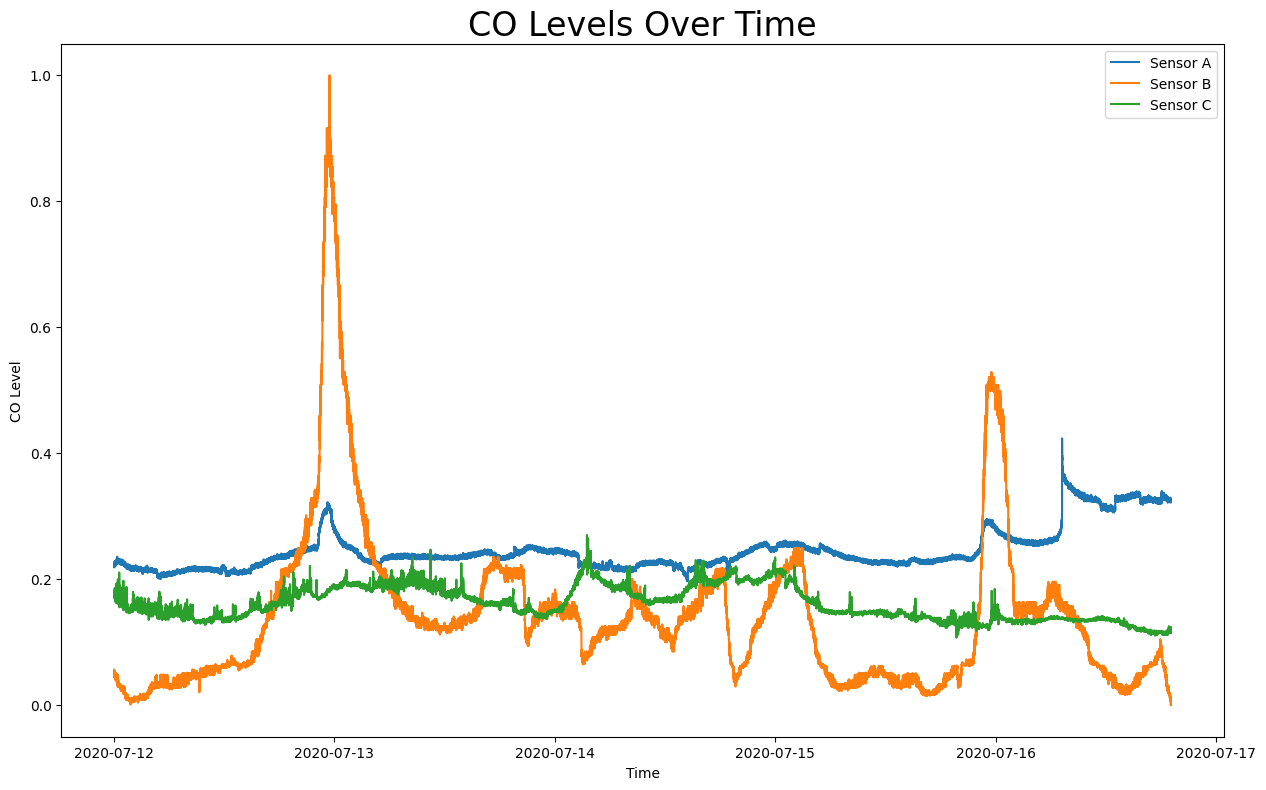

In [683]:
plt.figure(figsize=(15,9))
plt.plot(train_A["co"], label="Sensor A")
plt.plot(train_B["co"], label="Sensor B")
plt.plot(train_C["co"], label="Sensor C")
plt.title("CO Levels Over Time", size=24)
plt.xlabel("Time")
plt.ylabel("CO Level")
plt.legend()

In [684]:
list(train_A.columns)

['co', 'humidity', 'light', 'lpg', 'motion', 'smoke', 'temp']

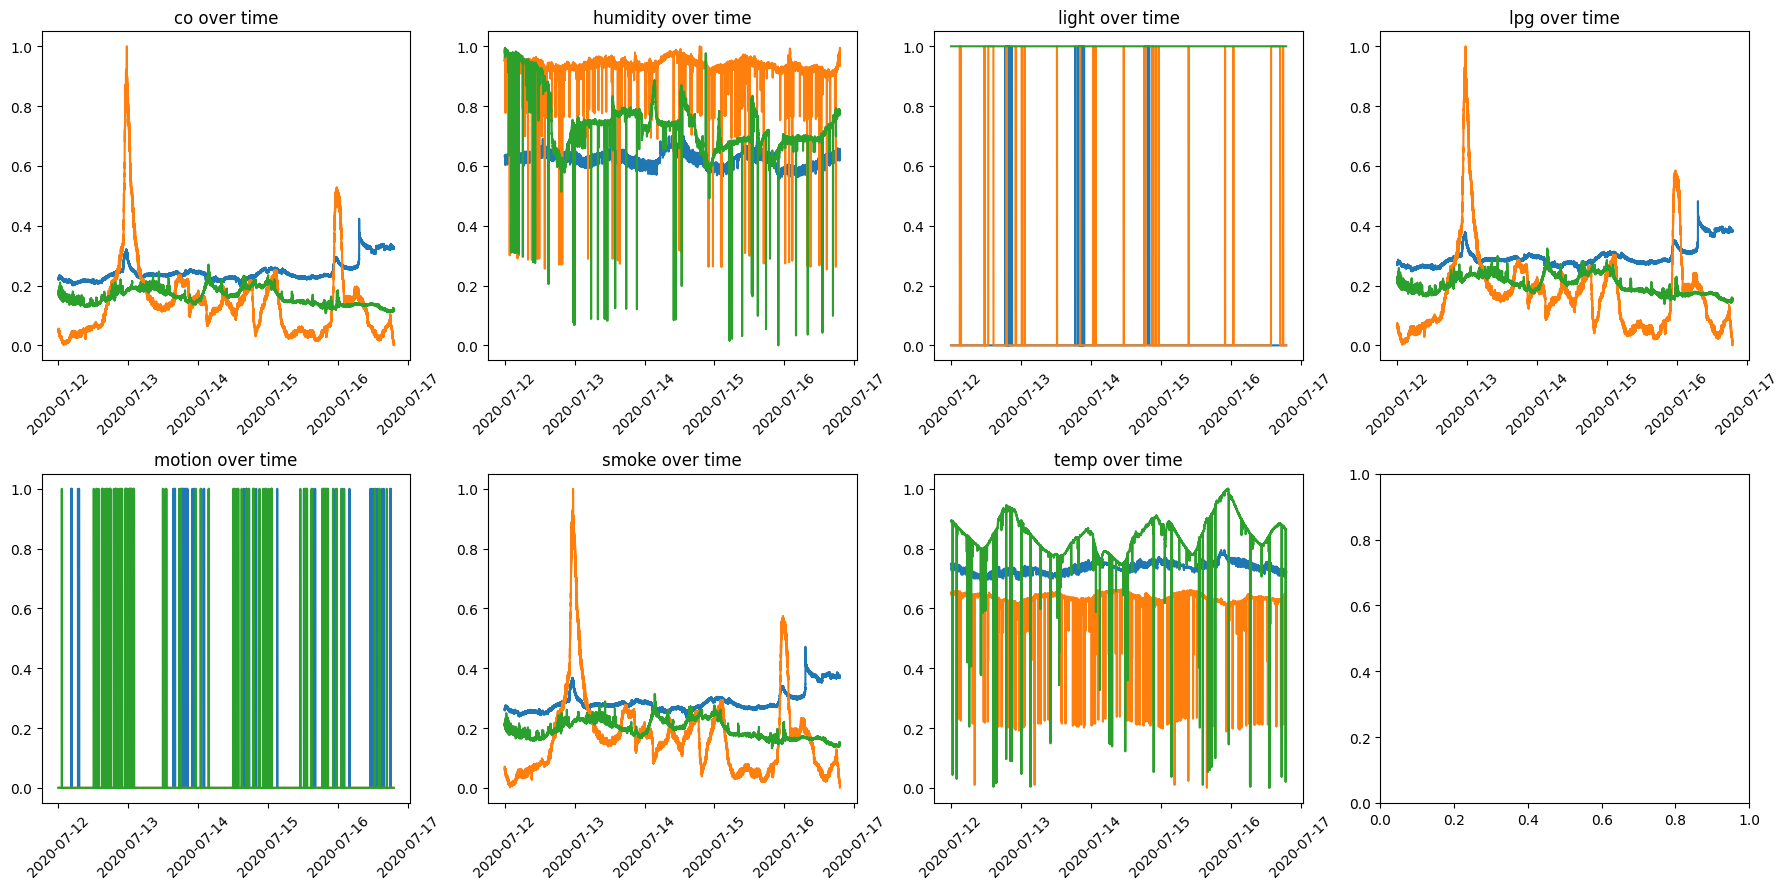

In [685]:
fig, axes = plt.subplots(2, 4, figsize=(18,9))
axes = axes.flatten()

for idx, column in enumerate(list(train_A.columns)):
  axes[idx].plot(train_A[column], label="Sensor A")
  axes[idx].plot(train_B[column], label="Sensor B")
  axes[idx].plot(train_C[column], label="Sensor C")
  axes[idx].set_title(f"{column} over time")
  axes[idx].tick_params(axis='x', rotation=45)
  axes[idx].legend
fig.set_tight_layout(True)

<Axes: >

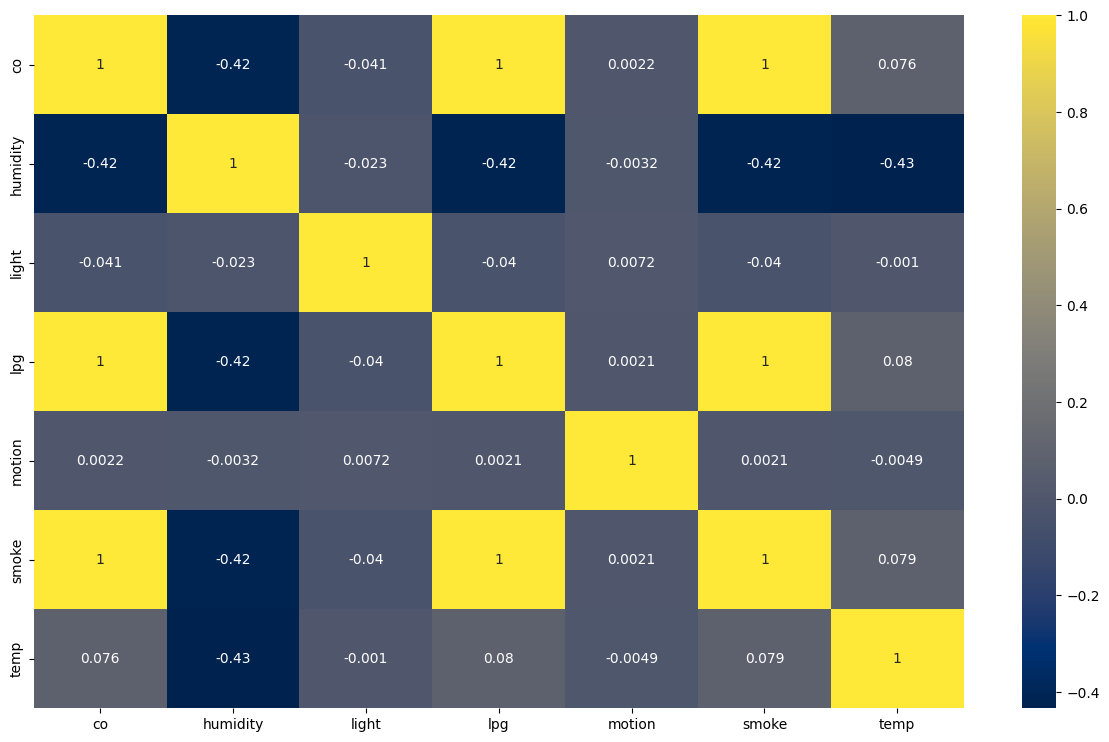

In [686]:
# I will just be using Sensor A from now on.
train_corr_a = train_A.corr()
plt.figure(figsize=(15,9))
sns.heatmap(train_corr_a, cmap="cividis", annot=True)

In [687]:
train_dataframes = [train_A, train_B, train_C]
valid_dataframes = [valid_A, valid_B, valid_C]
test_dataframes = [test_A, test_B, test_C]

In [688]:
dataframes = [train_dataframes, valid_dataframes, test_dataframes]
for each_set in dataframes:
  for sensor in each_set:
    sensor["co_lpg_smoke"] = (sensor["co"].values + sensor["lpg"].values + sensor["smoke"].values) / 3
    sensor.drop(columns=["co", "lpg", "smoke"], inplace=True)

In [689]:
train_C

,humidity,light,motion,temp,co_lpg_smoke
datetime,,,,,
2020-07-12 00:01:39.589145899,0.962868,1.0,0.0,0.891089,0.203171
2020-07-12 00:01:44.468410730,0.976953,1.0,0.0,0.891089,0.202094
2020-07-12 00:01:48.275381565,0.976953,1.0,0.0,0.891089,0.198013
2020-07-12 00:01:55.288542509,0.978233,1.0,0.0,0.891089,0.201381
2020-07-12 00:01:59.098013639,0.978233,1.0,0.0,0.891089,0.207505
...,...,...,...,...,...
2020-07-16 19:03:41.763034582,0.782330,1.0,0.0,0.864687,0.139226
2020-07-16 19:03:58.658017635,0.781050,1.0,0.0,0.864687,0.139226
2020-07-16 19:04:02.465259552,0.779770,1.0,0.0,0.864687,0.139226


In [690]:
new_columns = list(train_A.reset_index().columns)
print(new_columns)

['datetime', 'humidity', 'light', 'motion', 'temp', 'co_lpg_smoke']


[('datetime', 'humidity'), ('datetime', 'light'), ('datetime', 'motion'), ('datetime', 'temp'), ('datetime', 'co_lpg_smoke'), ('humidity', 'light'), ('humidity', 'motion'), ('humidity', 'temp'), ('humidity', 'co_lpg_smoke'), ('light', 'motion'), ('light', 'temp'), ('light', 'co_lpg_smoke'), ('motion', 'temp'), ('motion', 'co_lpg_smoke'), ('temp', 'co_lpg_smoke')]


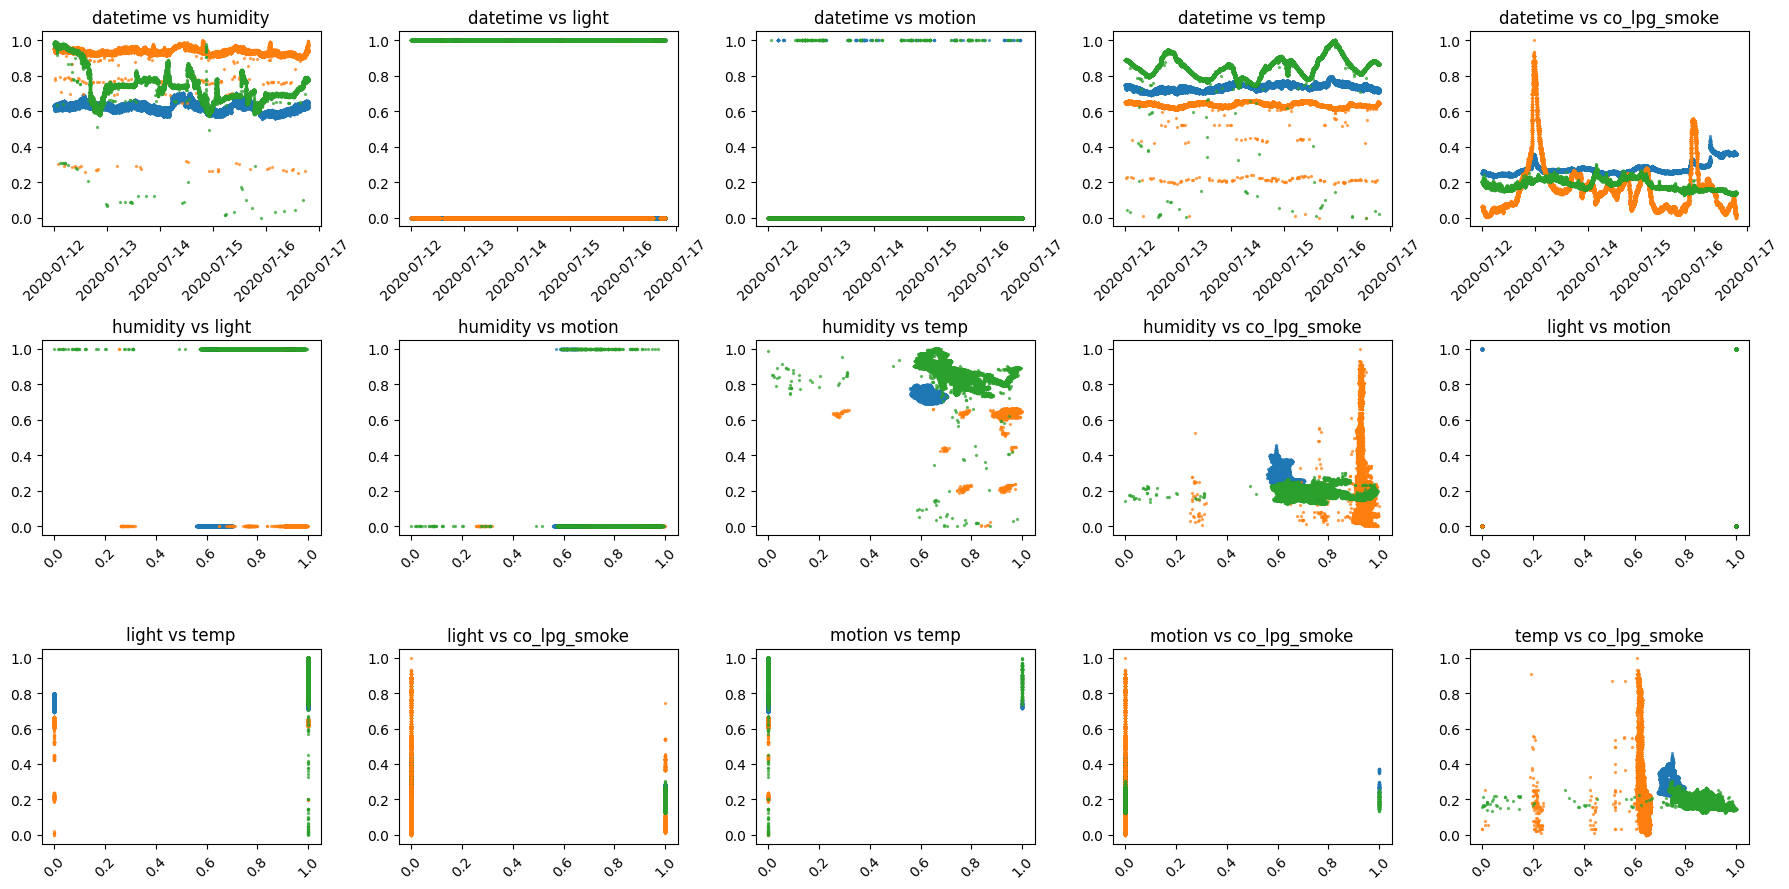

In [691]:
from itertools import combinations

fig, axes = plt.subplots(3, 5, figsize=(18,9))
axes = axes.flatten()

combinatorics = list(combinations(new_columns, 2))
print(combinatorics)

scatter_size = 2
alpha_count = 0.6

for idx, (x, y) in enumerate(combinatorics):
  axes[idx].scatter(train_A.reset_index()[x], train_A.reset_index()[y], label="Sensor A", s=scatter_size, alpha=alpha_count)
  axes[idx].scatter(train_B.reset_index()[x], train_B.reset_index()[y], label="Sensor B", s=scatter_size, alpha=alpha_count)
  axes[idx].scatter(train_C.reset_index()[x], train_C.reset_index()[y], label="Sensor C", s=scatter_size, alpha=alpha_count)
  axes[idx].tick_params(axis="x", rotation=45)
  axes[idx].set_title(f"{x} vs {y}")
fig.set_tight_layout(True)

In [692]:
def remove_outliers_quantile(df, column: str, lower_quartile: float = 0.01, upper_quartile: float = 0.99):
    """Returns a copy of the DataFrame with outliers removed from a specified column"""
    lower_bound = df[column].quantile(lower_quartile)
    upper_bound = df[column].quantile(upper_quartile)
    mask = (df[column] > lower_bound) & (df[column] < upper_bound)
    return df[mask]

In [693]:
train_A = remove_outliers_quantile(train_A, column="temp")
train_B = remove_outliers_quantile(train_B, column="temp")
train_C = remove_outliers_quantile(train_C, column="temp")

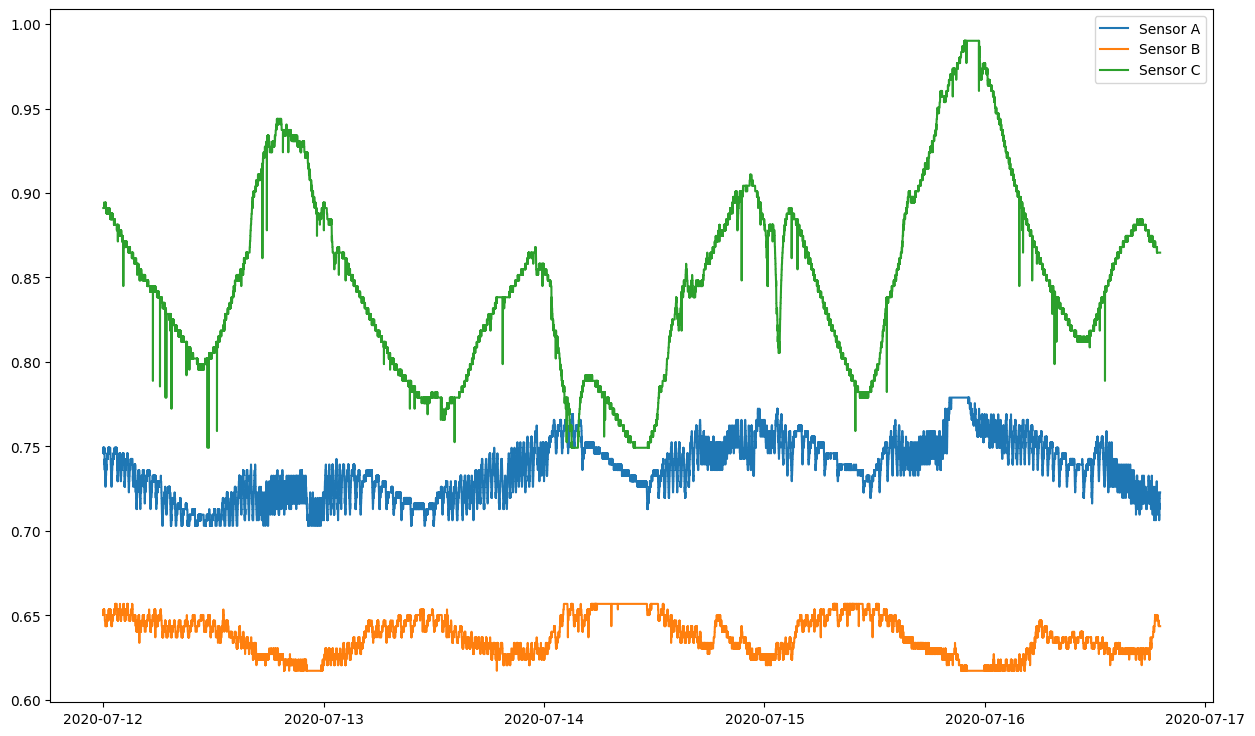

In [694]:
plt.figure(figsize=(15,9))
plt.plot(train_A.index, train_A["temp"], label="Sensor A")
plt.plot(train_B.index, train_B["temp"], label="Sensor B")
plt.plot(train_C.index, train_C["temp"], label="Sensor C")
plt.legend()

In [695]:
def rolling_windowing(df, column:str, window_count:int=10):
  if isinstance(df, pd.DataFrame):
    df[f"{column}_rolling_{window_count}"] = df[column].rolling(window=window_count, min_periods=1).mean()
  elif isinstance(df, pd.Series):
    df = pd.DataFrame({
        f"{column}": df,
        f"{column}_rolling_{window_count}": df.rolling(window=window_count, min_periods=1).mean()
        })
  else:
    raise ValueError("df must be a pandas Series or DataFrame")

  print(f"Mean rolling window for column '{column}' with a window of {window_count} values has been added to the dataframe.")
  return df

In [696]:
train_A = rolling_windowing(train_A, column="temp", window_count=1000)
train_B = rolling_windowing(train_B, column="temp", window_count=1000)
train_C = rolling_windowing(train_C, column="temp", window_count=1000)

Mean rolling window for column 'temp' with a window of 1000 values has been added to the dataframe.
Mean rolling window for column 'temp' with a window of 1000 values has been added to the dataframe.
Mean rolling window for column 'temp' with a window of 1000 values has been added to the dataframe.


/tmp/ipython-input-695-3763380202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{column}_rolling_{window_count}"] = df[column].rolling(window=window_count, min_periods=1).mean()
/tmp/ipython-input-695-3763380202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{column}_rolling_{window_count}"] = df[column].rolling(window=window_count, min_periods=1).mean()
/tmp/ipython-input-695-3763380202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [697]:
train_C

,humidity,light,motion,temp,co_lpg_smoke,temp_rolling_1000
datetime,,,,,,
2020-07-12 00:01:39.589145899,0.962868,1.0,0.0,0.891089,0.203171,0.891089
2020-07-12 00:01:44.468410730,0.976953,1.0,0.0,0.891089,0.202094,0.891089
2020-07-12 00:01:48.275381565,0.976953,1.0,0.0,0.891089,0.198013,0.891089
2020-07-12 00:01:55.288542509,0.978233,1.0,0.0,0.891089,0.201381,0.891089
2020-07-12 00:01:59.098013639,0.978233,1.0,0.0,0.891089,0.207505,0.891089
...,...,...,...,...,...,...
2020-07-16 19:03:41.763034582,0.782330,1.0,0.0,0.864687,0.139226,0.872191
2020-07-16 19:03:58.658017635,0.781050,1.0,0.0,0.864687,0.139226,0.872175
2020-07-16 19:04:02.465259552,0.779770,1.0,0.0,0.864687,0.139226,0.872158


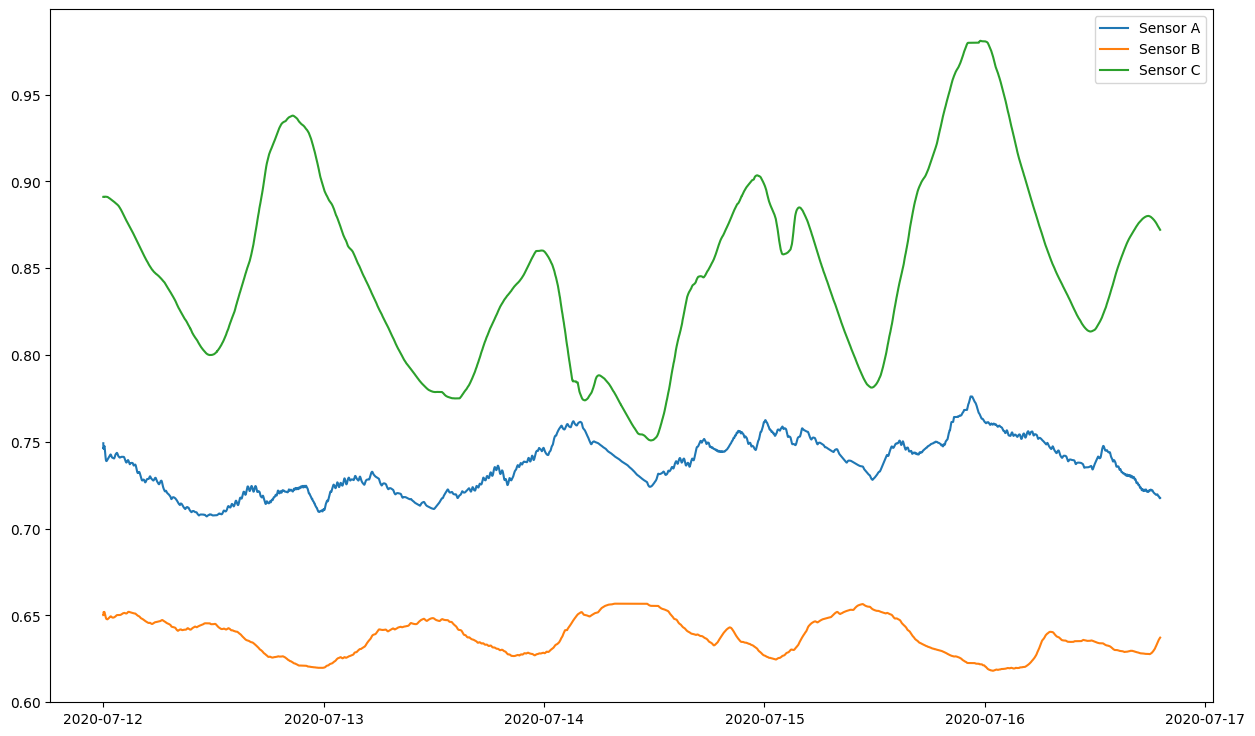

In [698]:
plt.figure(figsize=(15,9))
plt.plot(train_A.index, train_A["temp_rolling_1000"], label="Sensor A")
plt.plot(train_B.index, train_B["temp_rolling_1000"], label="Sensor B")
plt.plot(train_C.index, train_C["temp_rolling_1000"], label="Sensor C")
plt.legend()

In [699]:
import scipy as sp

# Machine Learning Part
This will the part where I will do machine learning to extrapolate the temperature on a given day! I will use a hybrid approach by detrending the series using a linear model and then using a non-linear model to model the seasonality.

In [700]:
def detrend_timeseries(df, target_column):
  """This will detrend a time-series dataframe, this will require the datetime column to be the index!"""
  linear_model = skl.linear_model.RidgeCV()
  # Convert datetime index to Unix timestamps (float) for the linear model
  time_index_numeric = df.index.astype(np.int64) // 10**9
  linear_model.fit(time_index_numeric.values.reshape(-1, 1), df[target_column])
  trend = linear_model.predict(time_index_numeric.values.reshape(-1, 1))
  df_detrended = df[target_column] - trend
  return df_detrended, trend, linear_model

def detrend_timeseries_poly(df, target_column, degree:int):
  """This will detrend a time-series dataframe using a polynomial model, this will require the datetime column to be the index!"""
  # Convert datetime index to Unix timestamps (float) for the polynomial model
  time_index_numeric = df.index.astype(np.int64) // 10**9
  pipeline = skl.pipeline.make_pipeline(skl.preprocessing.StandardScaler(), skl.preprocessing.PolynomialFeatures(degree), skl.linear_model.RidgeCV())
  pipeline.fit(time_index_numeric.values.reshape(-1, 1), df[target_column])
  trend = pipeline.predict(time_index_numeric.values.reshape(-1, 1))
  df_detrended = df[target_column] - trend
  return df_detrended, trend, pipeline

In [701]:
detrended_temp_A, trend_A, trend_model_A = detrend_timeseries_poly(train_A, "temp_rolling_1000",2)
detrended_temp_B, trend_B, trend_model_B = detrend_timeseries(train_B, "temp_rolling_1000")
detrended_temp_C, trend_C, trend_model_C = detrend_timeseries_poly(train_C, "temp_rolling_1000", 2)

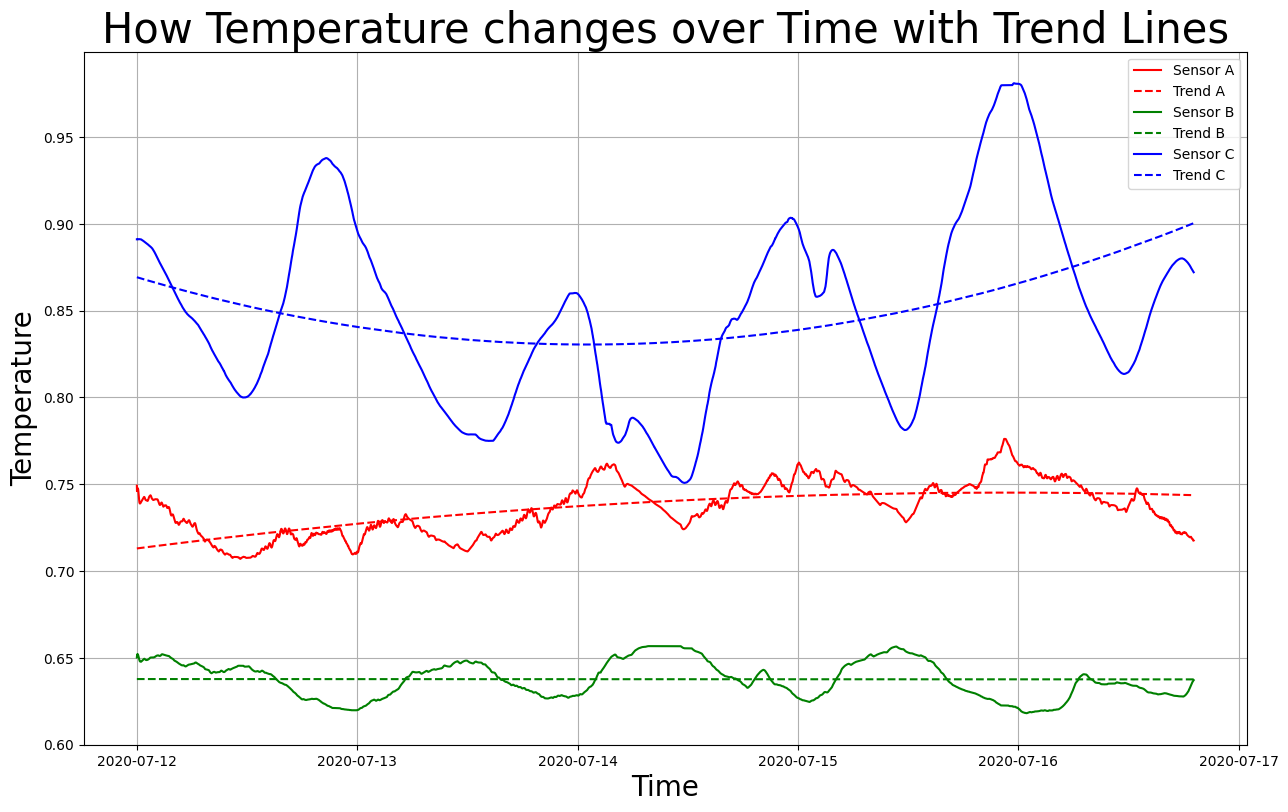

In [702]:
plt.figure(figsize=(15,9))
plt.plot(train_A.index, train_A["temp_rolling_1000"], label="Sensor A", c="red")
plt.plot(train_A.index, trend_A, linestyle="--", label="Trend A", c="red")
plt.plot(train_B.index, train_B["temp_rolling_1000"], label="Sensor B", c="green")
plt.plot(train_B.index, trend_B, linestyle="--", label="Trend B", c="green")
plt.plot(train_C.index, train_C["temp_rolling_1000"], label="Sensor C", c="blue")
plt.plot(train_C.index, trend_C, linestyle="--", label="Trend C", c="blue")
plt.legend()
plt.title("How Temperature changes over Time with Trend Lines", size=30)
plt.xlabel("Time", size=20)
plt.ylabel("Temperature", size=20)
plt.grid()

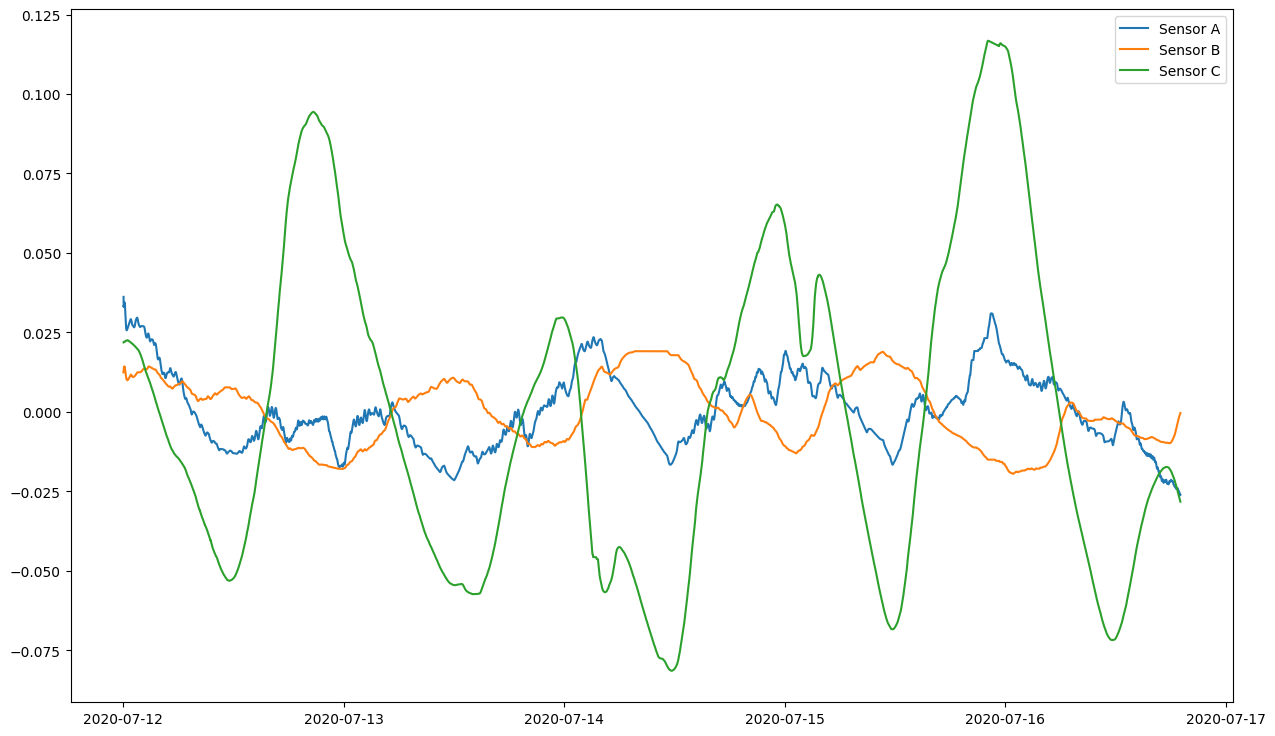

In [703]:
plt.figure(figsize=(15,9))
plt.plot(train_A.index, detrended_temp_A, label="Sensor A")
plt.plot(train_B.index, detrended_temp_B, label="Sensor B")
plt.plot(train_C.index, detrended_temp_C, label="Sensor C")
plt.legend()

In [704]:
import warnings

In [705]:
train_A

,humidity,light,motion,temp,co_lpg_smoke,temp_rolling_1000
datetime,,,,,,
2020-07-12 00:01:34.385974646,0.632522,0.0,0.0,0.749175,0.252145,0.749175
2020-07-12 00:01:38.073572874,0.631242,0.0,0.0,0.745875,0.253904,0.747525
2020-07-12 00:01:41.761234999,0.631242,0.0,0.0,0.745875,0.253146,0.746975
2020-07-12 00:01:45.448863506,0.631242,0.0,0.0,0.745875,0.253905,0.746700
2020-07-12 00:01:49.136686802,0.631242,0.0,0.0,0.745875,0.253400,0.746535
...,...,...,...,...,...,...
2020-07-16 19:04:00.386203289,0.655570,0.0,0.0,0.722772,0.361393,0.717551
2020-07-16 19:04:04.072103024,0.655570,0.0,0.0,0.722772,0.360525,0.717558
2020-07-16 19:04:07.758554220,0.656850,0.0,0.0,0.722772,0.359654,0.717564


In [706]:
lags = list(train_A.columns)[6:]
non_lags = list(train_A.columns)[:6]
print(non_lags)

['humidity', 'light', 'motion', 'temp', 'co_lpg_smoke', 'temp_rolling_1000']


In [707]:
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels as stats

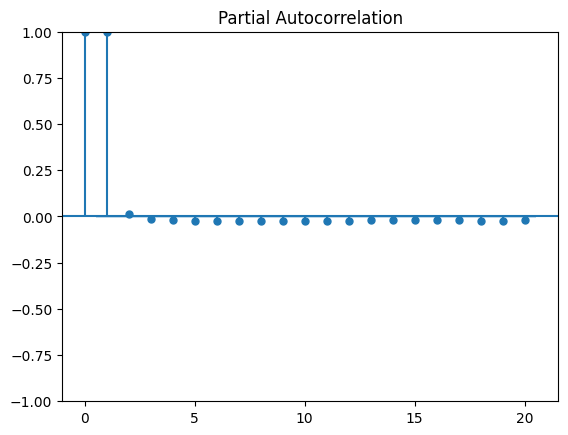

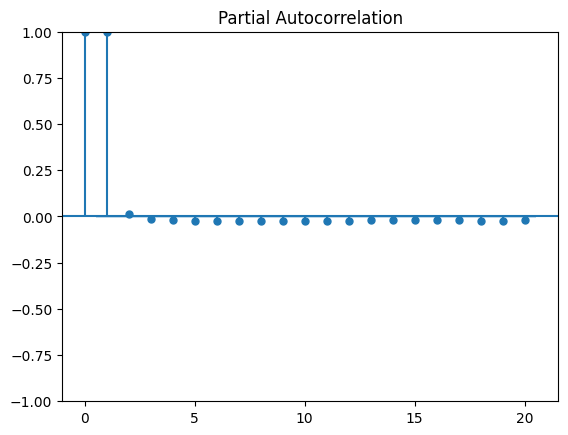

In [708]:
plot_pacf(train_A["temp_rolling_1000"], lags=20, method='ywm')

In [709]:
def lag_features(df, target_column, range_lag:int):
  """This will create lag features from 1 up until range_lag lags for a time-series dataframe, this will require the datetime column to be the index!"""
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for lag in range(1, range_lag + 1):
      df[f"{target_column}_lag_{lag}"] = df[target_column].shift(lag)
    return df

In [710]:
train_A = lag_features(train_A, "temp_rolling_1000", 3)
train_B = lag_features(train_B, "temp_rolling_1000", 3)
train_C = lag_features(train_C, "temp_rolling_1000", 3)

In [711]:
train_A

,humidity,light,motion,temp,co_lpg_smoke,temp_rolling_1000,temp_rolling_1000_lag_1,temp_rolling_1000_lag_2,temp_rolling_1000_lag_3
datetime,,,,,,,,,
2020-07-12 00:01:34.385974646,0.632522,0.0,0.0,0.749175,0.252145,0.749175,NaN,NaN,NaN
2020-07-12 00:01:38.073572874,0.631242,0.0,0.0,0.745875,0.253904,0.747525,0.749175,NaN,NaN
2020-07-12 00:01:41.761234999,0.631242,0.0,0.0,0.745875,0.253146,0.746975,0.747525,0.749175,NaN
2020-07-12 00:01:45.448863506,0.631242,0.0,0.0,0.745875,0.253905,0.746700,0.746975,0.747525,0.749175
2020-07-12 00:01:49.136686802,0.631242,0.0,0.0,0.745875,0.253400,0.746535,0.746700,0.746975,0.747525
...,...,...,...,...,...,...,...,...,...
2020-07-16 19:04:00.386203289,0.655570,0.0,0.0,0.722772,0.361393,0.717551,0.717548,0.717545,0.717541
2020-07-16 19:04:04.072103024,0.655570,0.0,0.0,0.722772,0.360525,0.717558,0.717551,0.717548,0.717545
2020-07-16 19:04:07.758554220,0.656850,0.0,0.0,0.722772,0.359654,0.717564,0.717558,0.717551,0.717548


In [712]:
import statsmodels.tsa.deterministic as smd
import statsmodels.api as sm

In [713]:
def make_fourier(df, target_col:str, period:int=43200, order:int=3):
  """This will fit a fourier transform into the dataframe, this will require datetime to be the index!"""
  fourier = smd.Fourier(period=period, order=order)

  # Use the dataframe's index for creating Fourier features
  X = fourier.in_sample(df.index)

  scaler = skl.preprocessing.StandardScaler()
  X_scaled = scaler.fit_transform(X)

  if isinstance(df, pd.Series):
    model = sm.OLS(df, X_scaled)
    results = model.fit()

  else:
    raise ValueError("df must be a pandas Series")

  return results

In [714]:
fourier_A = make_fourier(detrended_temp_A, "temp_rolling_1000", period=200000, order=7)
fourier_B = make_fourier(detrended_temp_B, "temp_rolling_1000", period=80000, order=6)
fourier_C = make_fourier(detrended_temp_C, "temp_rolling_1000", period=80000, order=6)

Text(0.5, 1.0, 'Fourier Feature Injection for Temperature Time Series Modeling')

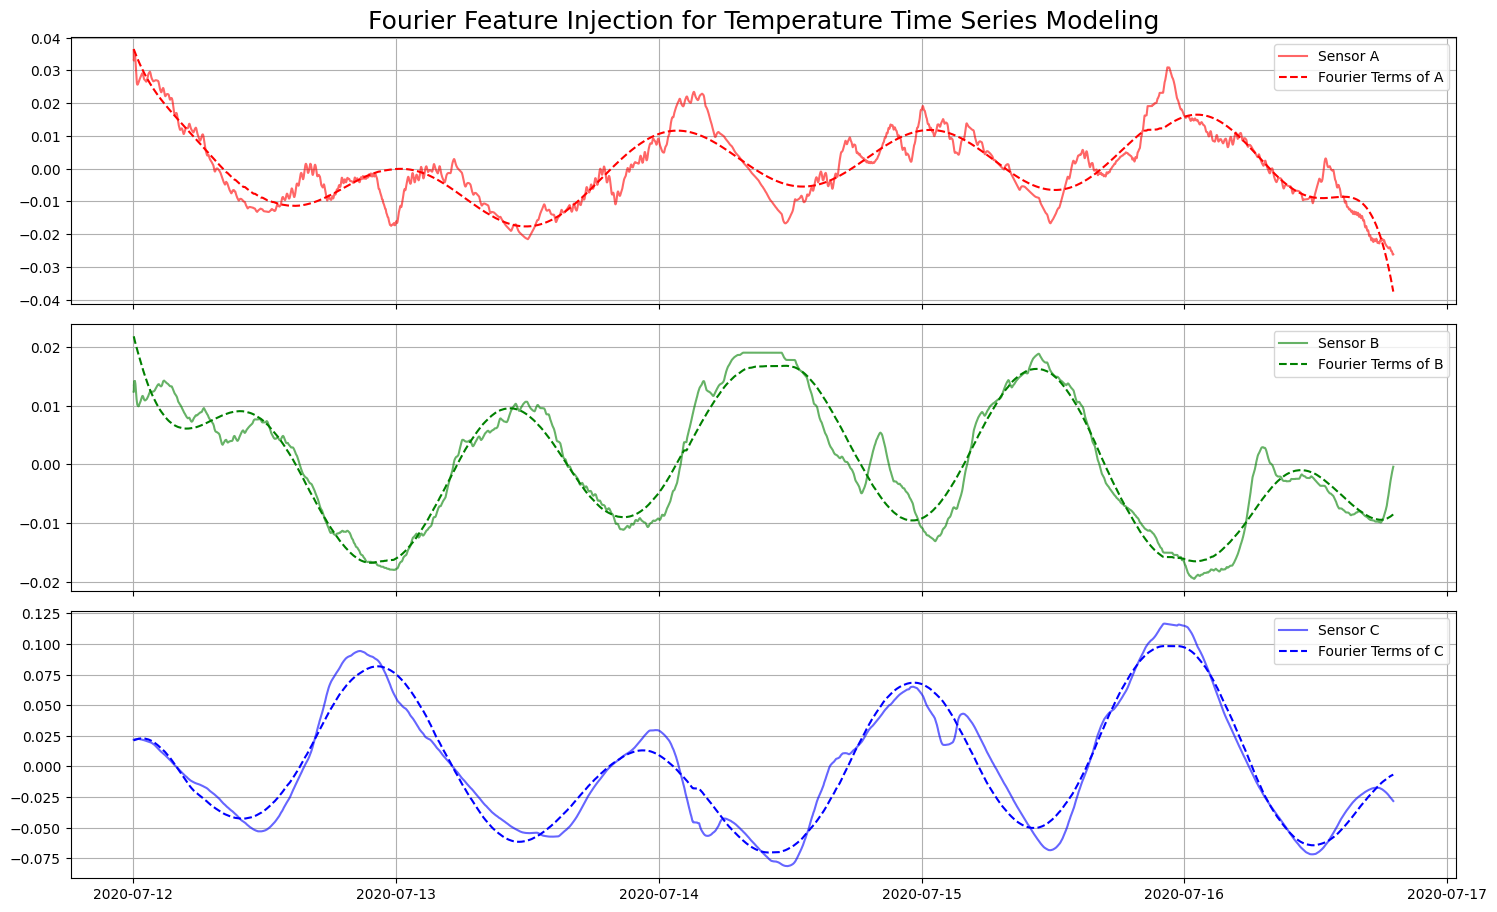

In [715]:
fig, axes = plt.subplots(3, 1, figsize=(15,9), sharex="all")
axes = axes.flatten()

axes[0].plot(train_A.index, detrended_temp_A, label="Sensor A", color="red", alpha=0.6)
axes[1].plot(train_B.index, detrended_temp_B, label="Sensor B", color="green", alpha=0.6)
axes[2].plot(train_C.index, detrended_temp_C, label="Sensor C", color="blue", alpha=0.6)

axes[0].plot(train_A.index, fourier_A.fittedvalues, label='Fourier Terms of A', color="red", linestyle="--")
axes[1].plot(train_B.index, fourier_B.fittedvalues, label='Fourier Terms of B', color="green", linestyle="--")
axes[2].plot(train_C.index, fourier_C.fittedvalues, label='Fourier Terms of C', color="blue", linestyle="--")

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[1].grid(True)
axes[2].grid(True)
axes[0].grid(True)

plt.tight_layout()
axes[0].set_title("Fourier Feature Injection for Temperature Time Series Modeling", size=18)

In [716]:
def validate_fourier(df_train, df_valid, target_col:str, period:int=43200, order:int=3):
  """This will fit a fourier transform into the dataframe and predict future values for the validation dataset, this will require datetime to be the index!"""
  fourier = smd.Fourier(period=period, order=order)

  # Use the dataframe's index for creating Fourier features
  X = fourier.in_sample(df_train.index)

  scaler = skl.preprocessing.StandardScaler()
  X_scaled = scaler.fit_transform(X)
  if isinstance(df_train, pd.Series):
    model = sm.OLS(df_train, X_scaled)
  else:
    model = sm.OLS(df_train[target_col], X_scaled)
  results = model.fit()

  X_valid = fourier.in_sample(df_valid.index)
  X_valid_scaled = scaler.transform(X_valid)

  predictions = results.predict(X_valid_scaled)
  return results, predictions

In [717]:
valid_A = rolling_windowing(valid_A, "temp", 1000)
valid_B = rolling_windowing(valid_B, "temp", 1000)
valid_C = rolling_windowing(valid_C, "temp", 1000)

Mean rolling window for column 'temp' with a window of 1000 values has been added to the dataframe.
Mean rolling window for column 'temp' with a window of 1000 values has been added to the dataframe.
Mean rolling window for column 'temp' with a window of 1000 values has been added to the dataframe.


In [718]:
def detrend_validation_sets(model, df_valid, target_column):
  time_index_numeric = df_valid.index.astype(np.int64) // 10**9
  trend = model.predict(time_index_numeric.values.reshape(-1, 1))

  if isinstance(df_valid, pd.Series):
    detrend_df = df_valid - trend
  elif isinstance(df_valid, pd.DataFrame):
    detrend_df = pd.Series(df_valid[target_column] - trend)
  else:
    raise ValueError("df must be a pandas Series or DataFrame")
  return detrend_df, trend

In [719]:
detrended_temp_A_valid, trend_A_valid = detrend_validation_sets(trend_model_A, valid_A, "temp_rolling_1000")
detrended_temp_B_valid, trend_B_valid = detrend_validation_sets(trend_model_B, valid_B, "temp_rolling_1000")
detrended_temp_C_valid, trend_C_valid = detrend_validation_sets(trend_model_C, valid_C, "temp_rolling_1000")

In [720]:
train_fourier_A, valid_fourier_A = validate_fourier(detrended_temp_A, detrended_temp_A_valid, "temp_rolling_1000", period=86400*7, order=7)
train_fourier_B, valid_fourier_B = validate_fourier(detrended_temp_B, detrended_temp_B_valid, "temp_rolling_1000", period=80000, order=6)
train_fourier_C, valid_fourier_C = validate_fourier(detrended_temp_C, detrended_temp_C_valid, "temp_rolling_1000", period=80000, order=6)

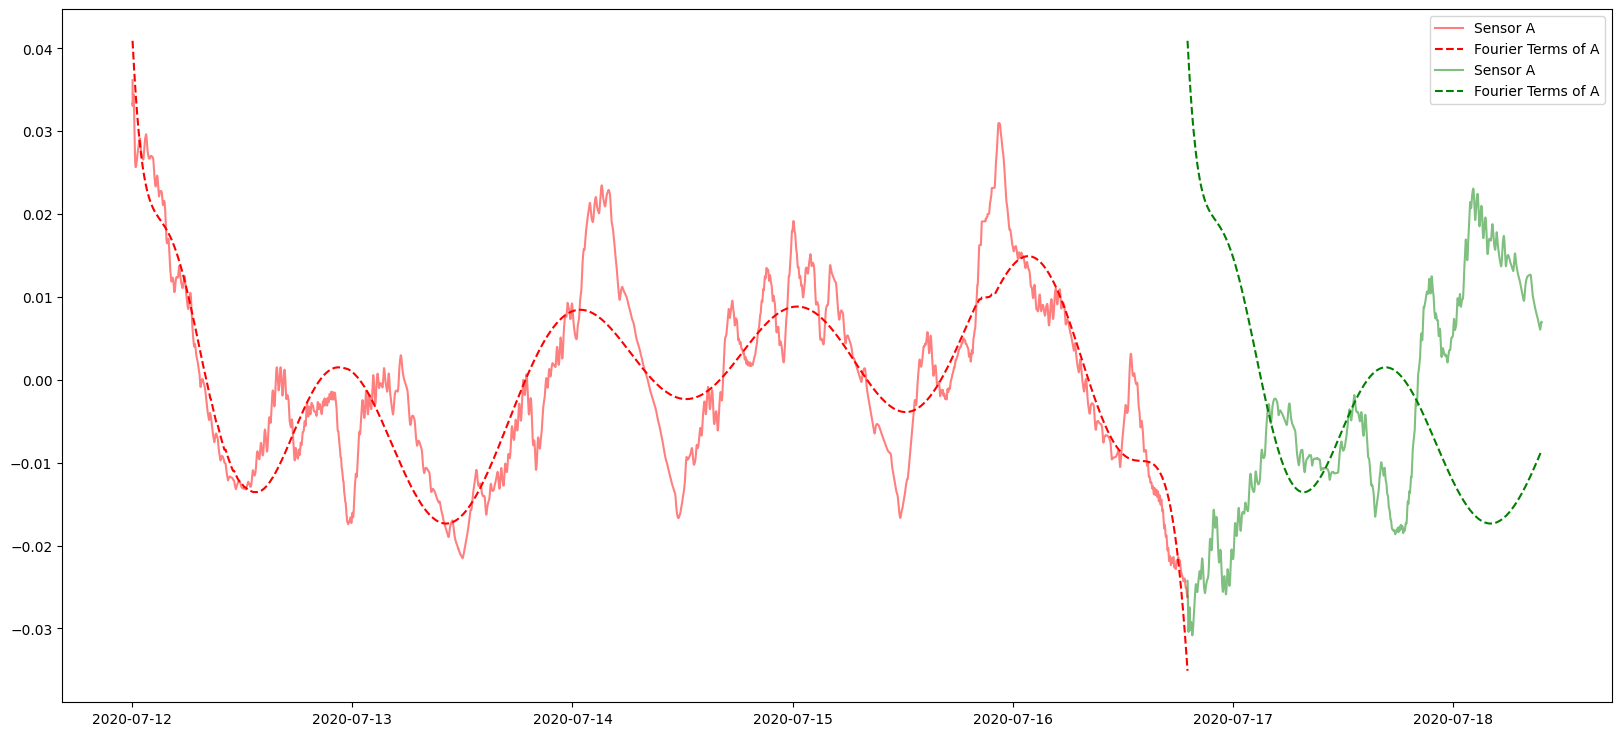

In [721]:
plt.figure(figsize=(20, 9))

plt.plot(train_A.index, detrended_temp_A, label="Sensor A", c="red", alpha=0.5)
plt.plot(train_A.index, train_fourier_A.fittedvalues, label='Fourier Terms of A', c="red", linestyle="--")

plt.plot(valid_A.index, detrended_temp_A_valid, label="Sensor A", c="green", alpha=0.5)
plt.plot(valid_A.index, valid_fourier_A, label='Fourier Terms of A', c="green", linestyle="--")

plt.legend()

## Fourier failed spectacularly!
Although we couldn't extrapolate out of the train set, we did find out that this data is NOT seasonal at all, and it's just random noise! We will now use other non-linear models to model this dataset and extrapolate temperature readings...

<Axes: xlabel='datetime'>

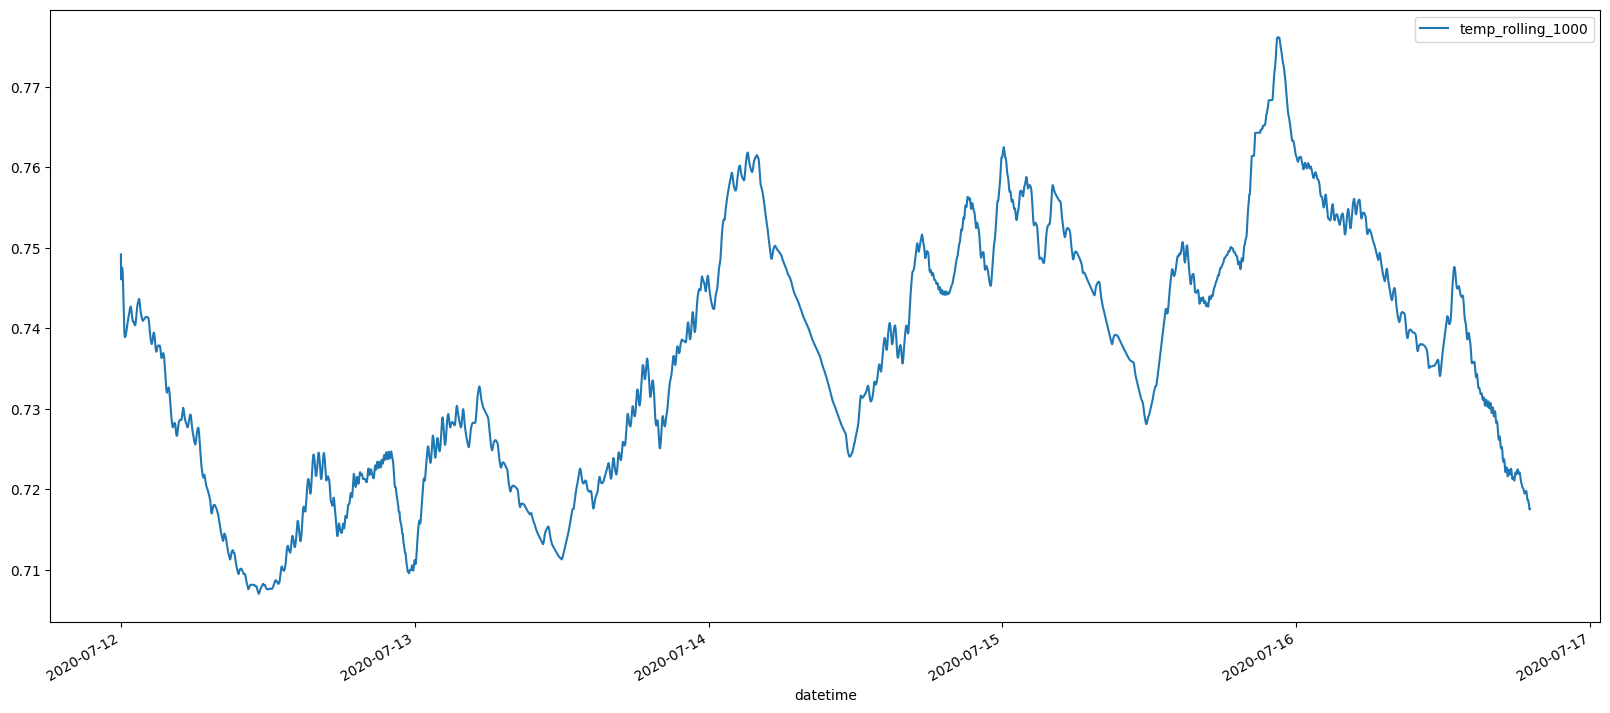

In [722]:
train_A.plot(y="temp_rolling_1000", figsize=(20,9))

In [758]:
detrend_train_A, trend_A, trend_model_A = detrend_timeseries_poly(train_A, "temp", 1)
detrend_train_B, trend_B, trend_model_B = detrend_timeseries_poly(train_B, "temp", 1)
detrend_train_C, trend_C, trend_model_C = detrend_timeseries_poly(train_C, "temp", 2)

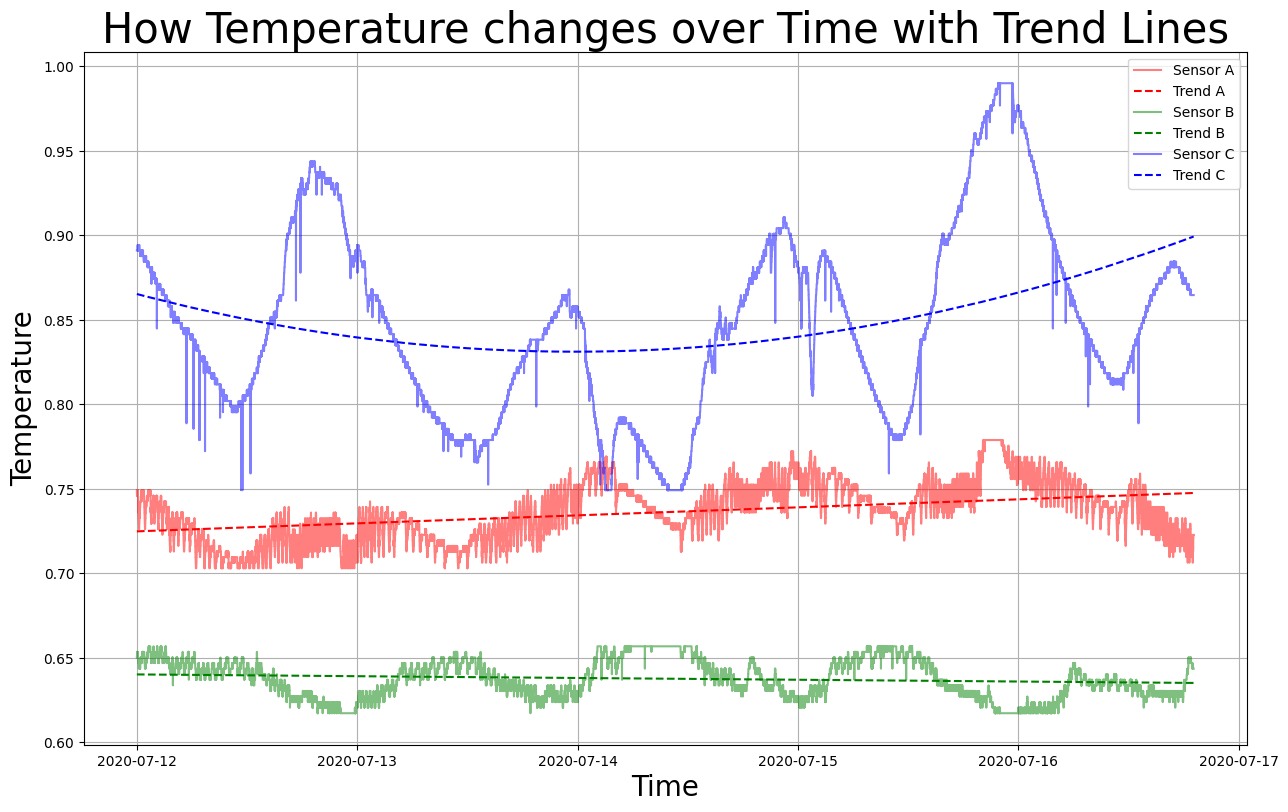

In [759]:
plt.figure(figsize=(15,9))
plt.plot(train_A.index, train_A["temp"], label="Sensor A", c="red", alpha=0.5)
plt.plot(train_A.index, trend_A, linestyle="--", label="Trend A", c="red")
plt.plot(train_B.index, train_B["temp"], label="Sensor B", c="green", alpha=0.5)
plt.plot(train_B.index, trend_B, linestyle="--", label="Trend B", c="green")
plt.plot(train_C.index, train_C["temp"], label="Sensor C", c="blue", alpha=0.5)
plt.plot(train_C.index, trend_C, linestyle="--", label="Trend C", c="blue")
plt.legend()
plt.title("How Temperature changes over Time with Trend Lines", size=30)
plt.xlabel("Time", size=20)
plt.ylabel("Temperature", size=20)
plt.grid()

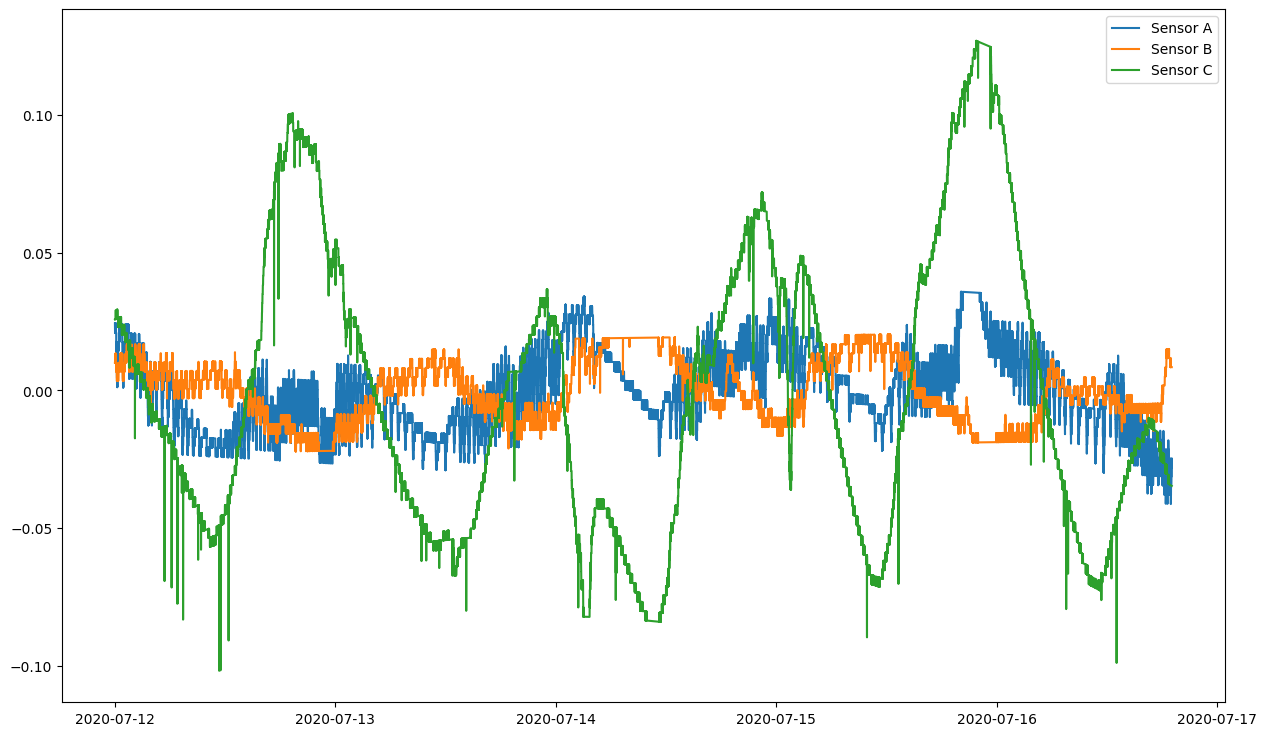

In [760]:
plt.figure(figsize=(15,9))
plt.plot(train_A.index, detrend_train_A, label="Sensor A")
plt.plot(train_B.index, detrend_train_B, label="Sensor B")
plt.plot(train_C.index, detrend_train_C, label="Sensor C")
plt.legend()

In [761]:
detrend_train_A = rolling_windowing(detrend_train_A, "temp", 1000)
detrend_train_B = rolling_windowing(detrend_train_B, "temp", 1000)
detrend_train_C = rolling_windowing(detrend_train_C, "temp", 1000)

Mean rolling window for column 'temp' with a window of 1000 values has been added to the dataframe.
Mean rolling window for column 'temp' with a window of 1000 values has been added to the dataframe.
Mean rolling window for column 'temp' with a window of 1000 values has been added to the dataframe.


In [762]:
detrend_train_A

,temp,temp_rolling_1000
datetime,,
2020-07-12 00:01:34.385974646,0.024353,0.024353
2020-07-12 00:01:38.073572874,0.021052,0.022702
2020-07-12 00:01:41.761234999,0.021052,0.022152
2020-07-12 00:01:45.448863506,0.021052,0.021877
2020-07-12 00:01:49.136686802,0.021052,0.021712
...,...,...
2020-07-16 19:04:00.386203289,-0.024769,-0.029889
2020-07-16 19:04:04.072103024,-0.024769,-0.029883
2020-07-16 19:04:07.758554220,-0.024770,-0.029877


In [763]:
def prepare_xgb(df):
  df = lag_features(df, "temp", 3)
  df["hour"] = df.index.hour
  df["day_of_week"] = df.index.dayofweek
  df["minute"] = df.index.minute
  return df

In [764]:
A_xgb_train = prepare_xgb(detrend_train_A)
B_xgb_train = prepare_xgb(detrend_train_B)
C_xgb_train = prepare_xgb(detrend_train_C)

In [765]:
detrend_valid_A, trend_A_valid = detrend_validation_sets(trend_model_A, valid_A, "temp")
detrend_valid_B, trend_B_valid = detrend_validation_sets(trend_model_B, valid_B, "temp")
detrend_valid_C, trend_C_valid = detrend_validation_sets(trend_model_C, valid_C, "temp")

In [766]:
detrend_valid_A = rolling_windowing(detrend_valid_A, "temp", 1000)
detrend_valid_B = rolling_windowing(detrend_valid_B, "temp", 1000)
detrend_valid_C = rolling_windowing(detrend_valid_C, "temp", 1000)

Mean rolling window for column 'temp' with a window of 1000 values has been added to the dataframe.
Mean rolling window for column 'temp' with a window of 1000 values has been added to the dataframe.
Mean rolling window for column 'temp' with a window of 1000 values has been added to the dataframe.


In [767]:
A_xgb_valid = prepare_xgb(detrend_valid_A)
B_xgb_valid = prepare_xgb(detrend_valid_B)
C_xgb_valid = prepare_xgb(detrend_valid_C)

In [768]:
from xgboost import XGBRegressor

In [769]:
def fit_xgb(train, valid):
  X_train = train.dropna()[["temp_rolling_1000", 'temp_lag_1', 'temp_lag_2', 'hour', 'day_of_week', "minute"]]
  y_train = train.dropna()['temp']

  X_valid = valid.dropna()[["temp_rolling_1000", 'temp_lag_1', 'temp_lag_2', 'hour', 'day_of_week', "minute"]]
  y_valid = valid.dropna()['temp']

  model = XGBRegressor(early_stopping_rounds=10, learning_rate=0.05)
  model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
  train_preds, valid_preds = model.predict(X_train), model.predict(X_valid)
  return model, train_preds, valid_preds

In [770]:
XGBA_model, A_preds, A_future_preds = fit_xgb(A_xgb_train, A_xgb_valid)
XGBB_model, B_preds, B_future_preds = fit_xgb(B_xgb_train, B_xgb_valid)
XGBC_model, C_preds, C_future_preds = fit_xgb(C_xgb_train, C_xgb_valid)

[0]	validation_0-rmse:0.01897
[1]	validation_0-rmse:0.01805
[2]	validation_0-rmse:0.01718
[3]	validation_0-rmse:0.01636
[4]	validation_0-rmse:0.01557
[5]	validation_0-rmse:0.01482
[6]	validation_0-rmse:0.01412
[7]	validation_0-rmse:0.01344
[8]	validation_0-rmse:0.01280
[9]	validation_0-rmse:0.01219
[10]	validation_0-rmse:0.01162
[11]	validation_0-rmse:0.01107
[12]	validation_0-rmse:0.01055
[13]	validation_0-rmse:0.01006
[14]	validation_0-rmse:0.00959
[15]	validation_0-rmse:0.00914
[16]	validation_0-rmse:0.00872
[17]	validation_0-rmse:0.00832
[18]	validation_0-rmse:0.00795
[19]	validation_0-rmse:0.00759
[20]	validation_0-rmse:0.00724
[21]	validation_0-rmse:0.00692
[22]	validation_0-rmse:0.00662
[23]	validation_0-rmse:0.00633
[24]	validation_0-rmse:0.00605
[25]	validation_0-rmse:0.00579
[26]	validation_0-rmse:0.00555
[27]	validation_0-rmse:0.00532
[28]	validation_0-rmse:0.00510
[29]	validation_0-rmse:0.00489
[30]	validation_0-rmse:0.00469
[31]	validation_0-rmse:0.00450
[32]	validation_0-

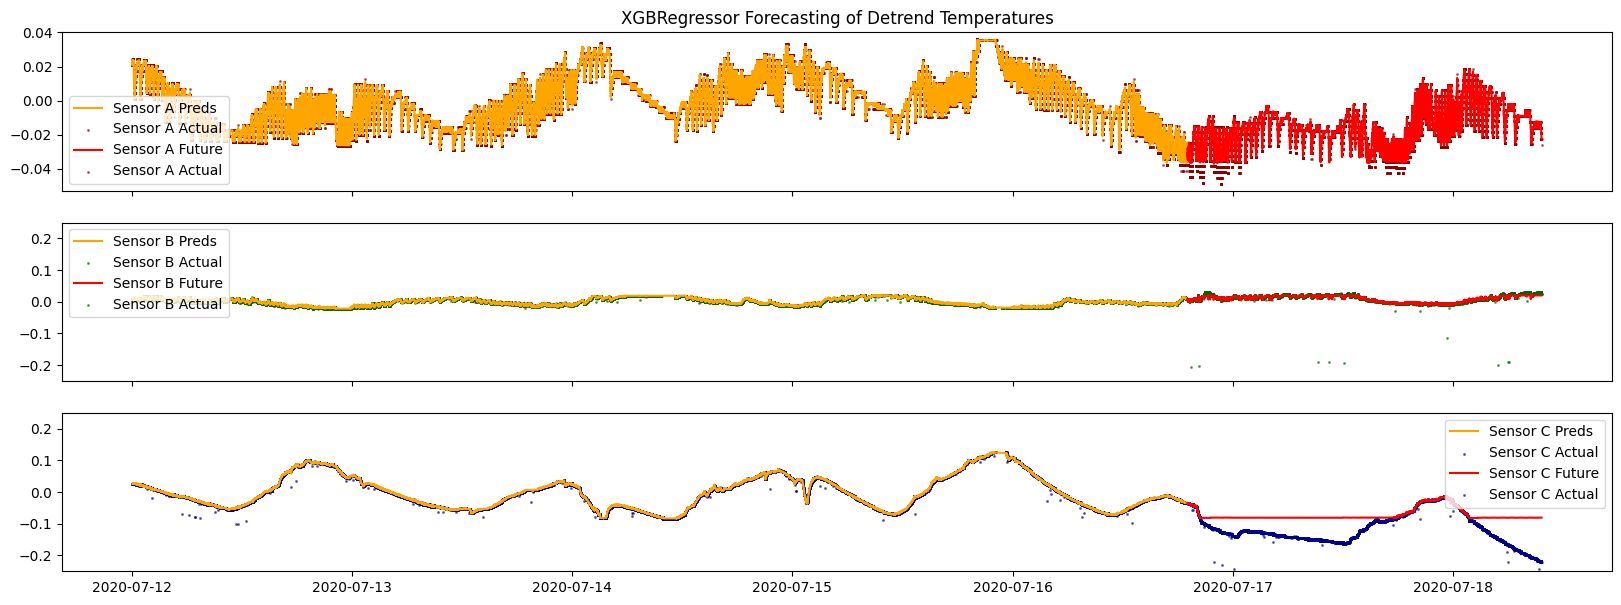

In [771]:
train_preds = [A_preds, B_preds, C_preds]
valid_preds = [A_future_preds, B_future_preds, C_future_preds]

fig, axes = plt.subplots(3, 1, figsize=(20,7), sharex="all")
axes = axes.flatten()

axes[1].set_ylim(-0.25, 0.25)
axes[2].set_ylim(-0.25, 0.25)

axes[0].plot(A_xgb_train.dropna().index, A_preds, label="Sensor A Preds", c="orange", alpha=1)
axes[1].plot(B_xgb_train.dropna().index, B_preds, label="Sensor B Preds", c="orange", alpha=1)
axes[2].plot(C_xgb_train.dropna().index, C_preds, label="Sensor C Preds", c="orange", alpha=1)

axes[0].scatter(A_xgb_train.index, A_xgb_train["temp"], label="Sensor A Actual", c="darkred", alpha=0.5, s=1.3)
axes[1].scatter(B_xgb_train.index, B_xgb_train["temp"], label="Sensor B Actual", c="darkgreen", alpha=0.5, s=1.3)
axes[2].scatter(C_xgb_train.index, C_xgb_train["temp"], label="Sensor C Actual", c="darkblue", alpha=0.5, s=1.3)

axes[0].plot(A_xgb_valid.dropna().index, A_future_preds, label="Sensor A Future", c="red", alpha=1)
axes[1].plot(B_xgb_valid.dropna().index, B_future_preds, label="Sensor B Future", c="red", alpha=1)
axes[2].plot(C_xgb_valid.dropna().index, C_future_preds, label="Sensor C Future", c="red", alpha=1)

axes[0].scatter(A_xgb_valid.index, A_xgb_valid["temp"], label="Sensor A Actual", c="darkred", alpha=0.5, s=1.3)
axes[1].scatter(B_xgb_valid.index, B_xgb_valid["temp"], label="Sensor B Actual", c="darkgreen", alpha=0.5, s=1.3)
axes[2].scatter(C_xgb_valid.index, C_xgb_valid["temp"], label="Sensor C Actual", c="darkblue", alpha=0.5, s=1.3)

axes[0].set_title("XGBRegressor Forecasting of Detrend Temperatures")
axes[0].legend()
axes[1].legend()
axes[2].legend()

plt.legend()

In [785]:
def put_back_trend(trend_model, df_valid, valid_preds):
  time_index_numeric = df_valid.index.astype(np.int64) // 10**9
  trend = trend_model.predict(time_index_numeric.values.reshape(-1, 1))
  trended = pd.DataFrame({
      "temp": valid_preds + trend[3:]
  }, index=df_valid.index[3:])
  return trended

In [786]:
XGBA_validation = put_back_trend(trend_model_A, A_xgb_valid, A_future_preds)
XGBB_validation = put_back_trend(trend_model_B, B_xgb_valid, B_future_preds)
XGBC_validation = put_back_trend(trend_model_C, C_xgb_valid, C_future_preds)

In [787]:
train_A

,humidity,light,motion,temp,co_lpg_smoke,temp_rolling_1000,temp_rolling_1000_lag_1,temp_rolling_1000_lag_2,temp_rolling_1000_lag_3
datetime,,,,,,,,,
2020-07-12 00:01:34.385974646,0.632522,0.0,0.0,0.749175,0.252145,0.749175,NaN,NaN,NaN
2020-07-12 00:01:38.073572874,0.631242,0.0,0.0,0.745875,0.253904,0.747525,0.749175,NaN,NaN
2020-07-12 00:01:41.761234999,0.631242,0.0,0.0,0.745875,0.253146,0.746975,0.747525,0.749175,NaN
2020-07-12 00:01:45.448863506,0.631242,0.0,0.0,0.745875,0.253905,0.746700,0.746975,0.747525,0.749175
2020-07-12 00:01:49.136686802,0.631242,0.0,0.0,0.745875,0.253400,0.746535,0.746700,0.746975,0.747525
...,...,...,...,...,...,...,...,...,...
2020-07-16 19:04:00.386203289,0.655570,0.0,0.0,0.722772,0.361393,0.717551,0.717548,0.717545,0.717541
2020-07-16 19:04:04.072103024,0.655570,0.0,0.0,0.722772,0.360525,0.717558,0.717551,0.717548,0.717545
2020-07-16 19:04:07.758554220,0.656850,0.0,0.0,0.722772,0.359654,0.717564,0.717558,0.717551,0.717548


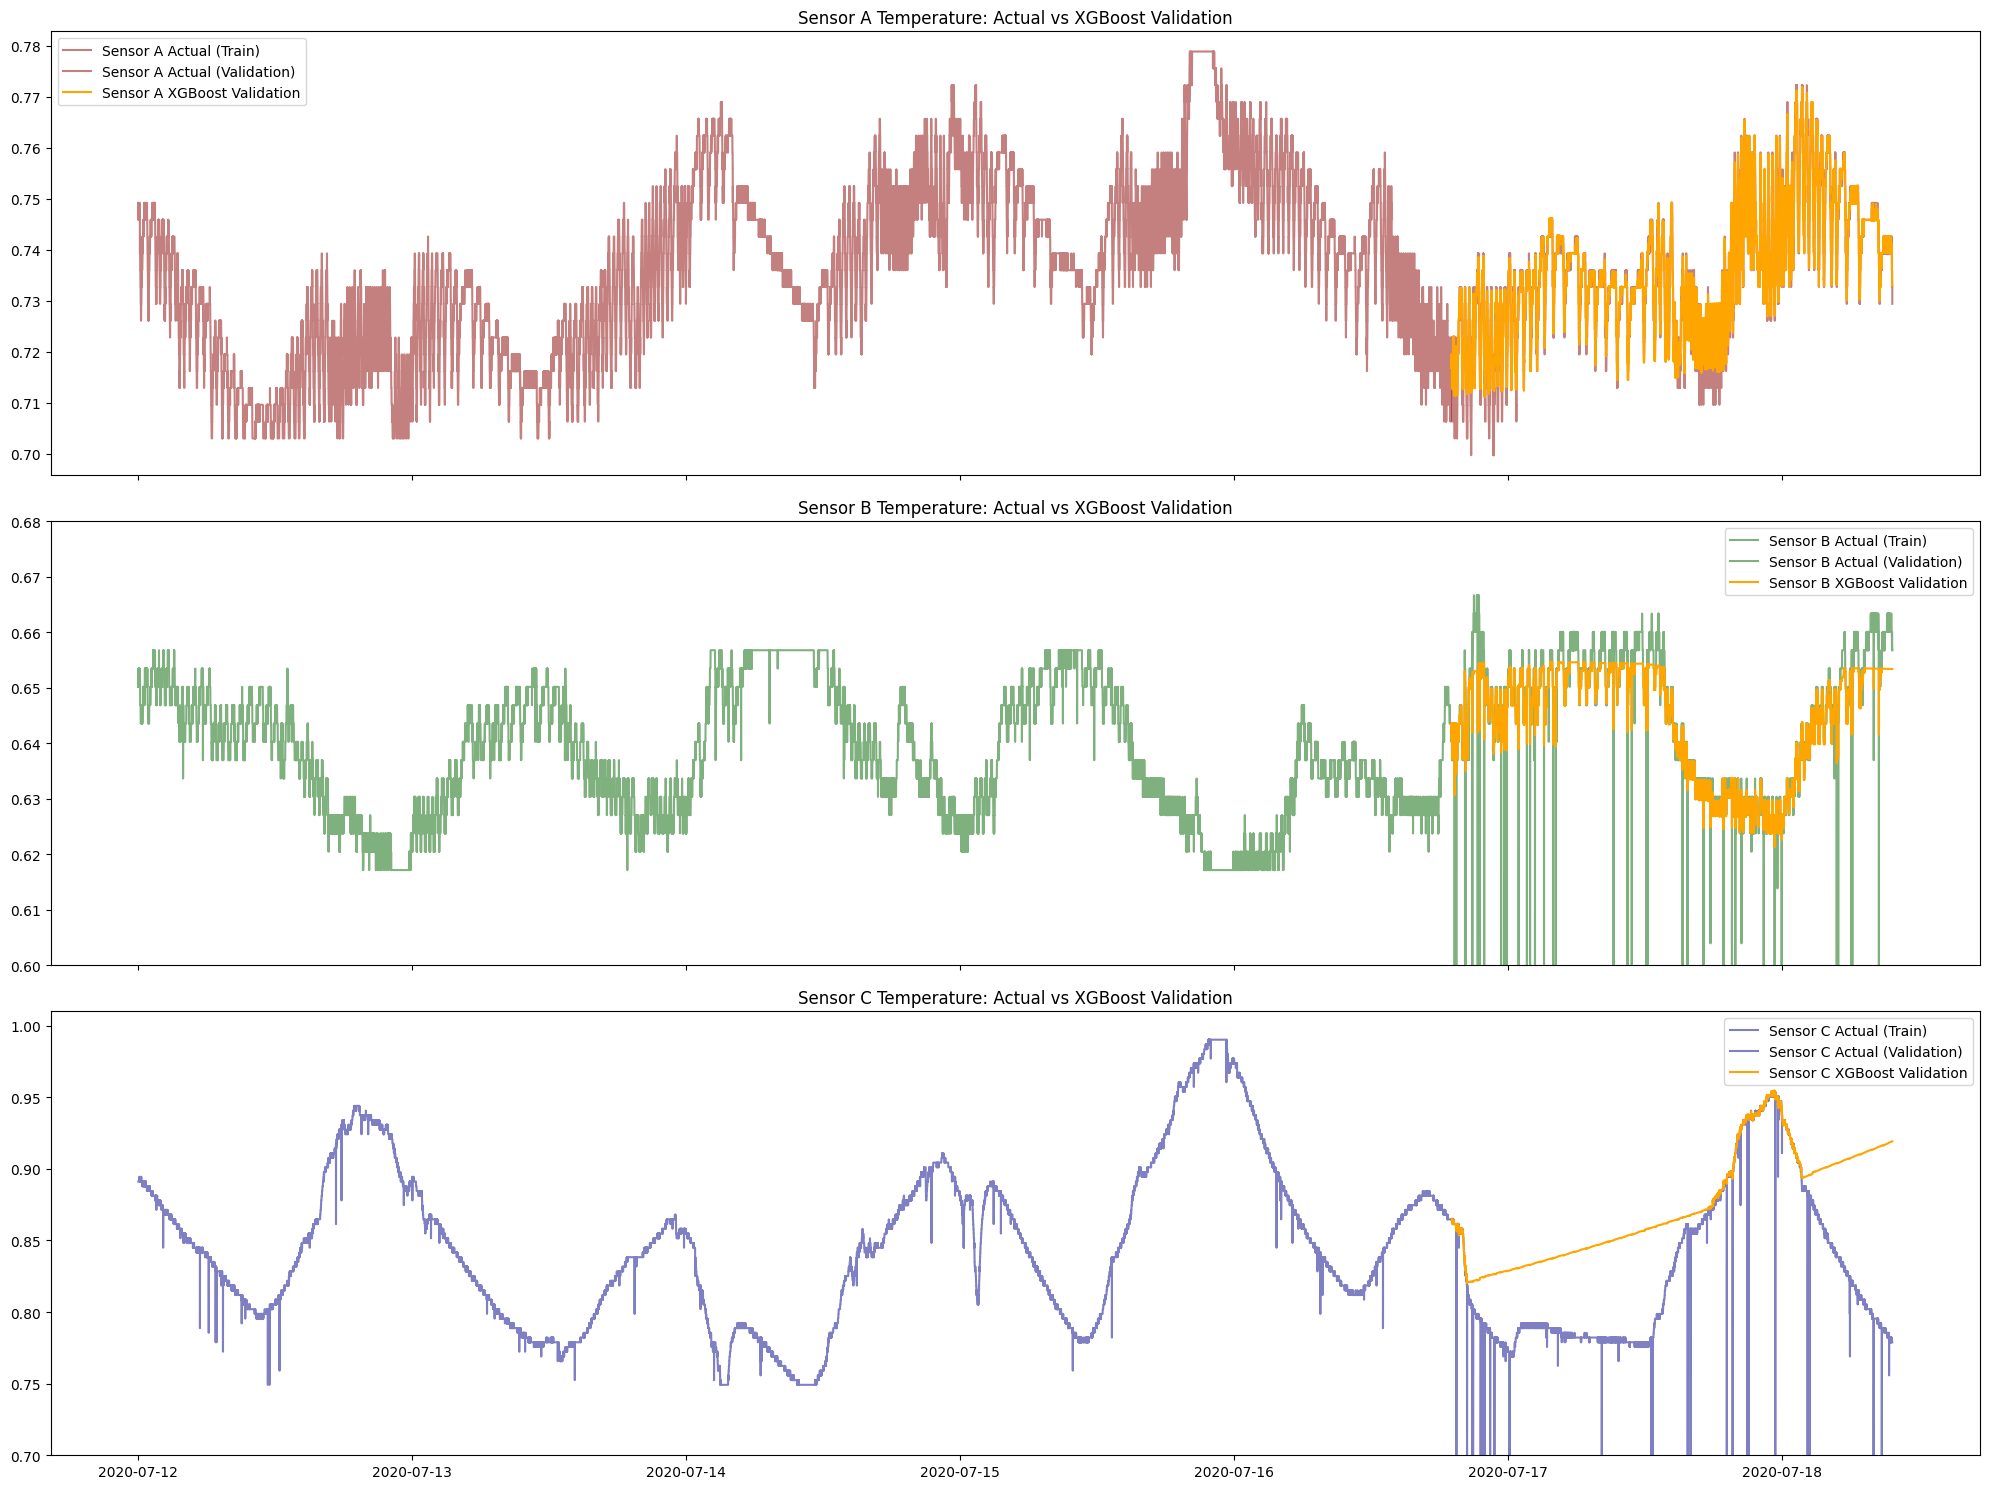

In [799]:
fig, axes = plt.subplots(3, 1, figsize=(20, 15), sharex="all")
axes = axes.flatten()

# Plot for Sensor A
axes[0].plot(train_A.index, train_A["temp"], label="Sensor A Actual (Train)", c="darkred", alpha=0.5)
axes[0].plot(valid_A.index, valid_A["temp"], label="Sensor A Actual (Validation)", c="darkred", alpha=0.5)
axes[0].plot(XGBA_validation.index, XGBA_validation["temp"], label="Sensor A XGBoost Validation", c="orange", alpha=1)
axes[0].set_title("Sensor A Temperature: Actual vs XGBoost Validation")
axes[0].legend()

# Plot for Sensor B
axes[1].plot(train_B.index, train_B["temp"], label="Sensor B Actual (Train)", c="darkgreen", alpha=0.5)
axes[1].plot(valid_B.index, valid_B["temp"], label="Sensor B Actual (Validation)", c="darkgreen", alpha=0.5)
axes[1].plot(XGBB_validation.index, XGBB_validation["temp"], label="Sensor B XGBoost Validation", c="orange", alpha=1)
axes[1].set_title("Sensor B Temperature: Actual vs XGBoost Validation")
axes[1].legend()
axes[1].set_ylim(0.6, 0.68)

# Plot for Sensor C
axes[2].plot(train_C.index, train_C["temp"], label="Sensor C Actual (Train)", c="darkblue", alpha=0.5)
axes[2].plot(valid_C.index, valid_C["temp"], label="Sensor C Actual (Validation)", c="darkblue", alpha=0.5)
axes[2].plot(XGBC_validation.index, XGBC_validation["temp"], label="Sensor C XGBoost Validation", c="orange", alpha=1)
axes[2].set_title("Sensor C Temperature: Actual vs XGBoost Validation")
axes[2].legend()
axes[2].set_ylim(0.7, 1.01)

plt.tight_layout()
plt.show()